In [1]:
# Librerías para importar de Drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1GHkj1Xv5hiH9piJ4-Ry4nCXM0PVs8yb-' #<-- ID del archivo con las imágenes
file_2 = '137RJ58BrXf5dW7u-0WzQJROsQ4N7EKEe'  #<-- ID del checkpoint con el modelo
file_3 = '1fEnhTR_O2jR_9ch29N6HQsd2yA-55F8S'  #<-- ID del optimizer
download = drive.CreateFile({'id': file_id})
download2 = drive.CreateFile({'id': file_2})
download3 = drive.CreateFile({'id': file_3})


# Download the file to a local disc
download.GetContentFile('archive.zip')
download2.GetContentFile('checkpoint.pt')
download3.GetContentFile('optimizer.pth')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import PIL
import os
from torchvision import models
import time

device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
#Organización de carpetas
!unzip archive.zip
os.rename(r"/content/Decks/Cracked", r"/content/Decks/Cracked_Deck")
os.rename(r"/content/Decks/Non-cracked", r"/content/Decks/Non-cracked_Deck")
os.rename(r"/content/Pavements/Cracked", r"/content/Pavements/Cracked_Pavement")
os.rename(r"/content/Pavements/Non-cracked", r"/content/Pavements/Non-cracked_Pavement")
os.rename(r"/content/Walls/Cracked", r"/content/Walls/Cracked_Wall")
os.rename(r"/content/Walls/Non-cracked", r"/content/Walls/Non-cracked_Wall")
!mkdir Defectos_estructurales
!cp -r /content/Decks/Cracked_Deck/ Defectos_estructurales/
!cp -r /content/Decks/Non-cracked_Deck/ Defectos_estructurales/
!cp -r /content/Pavements/Cracked_Pavement/ Defectos_estructurales/
!cp -r /content/Pavements/Non-cracked_Pavement/ Defectos_estructurales/
!cp -r /content/Walls/Cracked_Wall/ Defectos_estructurales/
!cp -r /content/Walls/Non-cracked_Wall/ Defectos_estructurales/
!rm -r Pavements/
!rm -r Walls/
!rm -r Decks/

#Descarga de modelos
!mkdir saved_data
!cp -r checkpoint.pt /content/saved_data/
!rm -r checkpoint.pt
!cp -r optimizer.pth /content/saved_data/
!rm -r optimizer.pth


Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: Walls/Non-cracked/7117-203.jpg  
  inflating: Walls/Non-cracked/7117-204.jpg  
  inflating: Walls/Non-cracked/7117-205.jpg  
  inflating: Walls/Non-cracked/7117-206.jpg  
  inflating: Walls/Non-cracked/7117-207.jpg  
  inflating: Walls/Non-cracked/7117-208.jpg  
  inflating: Walls/Non-cracked/7117-21.jpg  
  inflating: Walls/Non-cracked/7117-211.jpg  
  inflating: Walls/Non-cracked/7117-212.jpg  
  inflating: Walls/Non-cracked/7117-213.jpg  
  inflating: Walls/Non-cracked/7117-214.jpg  
  inflating: Walls/Non-cracked/7117-215.jpg  
  inflating: Walls/Non-cracked/7117-216.jpg  
  inflating: Walls/Non-cracked/7117-217.jpg  
  inflating: Walls/Non-cracked/7117-218.jpg  
  inflating: Walls/Non-cracked/7117-219.jpg  
  inflating: Walls/Non-cracked/7117-22.jpg  
  inflating: Walls/Non-cracked/7117-220.jpg  
  inflating: Walls/Non-cracked/7117-221.jpg  
  inflating: Walls/Non-cracked/7117-222.jpg  
  inflating: Wa

In [5]:
#Definición de parámetros
num_clases = 6
num_epocas = 1
batch_size_train = 16
batch_size_test = 64
learning_rate = 0.01
step_log = 40
#batch_size_train*step_log
#Brinda una actualización cada 1280 imágenes
train_factor = 0.75

#Separación del dataset en train y test
torch_dataset = torchvision.datasets.ImageFolder('Defectos_estructurales',transforms.Compose([transforms.RandomResizedCrop(224), transforms.ToTensor(),  transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]))
train_size = int(len(torch_dataset)*train_factor)
train_dataset, test_dataset = torch.utils.data.random_split(torch_dataset, [train_size, len(torch_dataset)-train_size])


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size = batch_size_train,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size = batch_size_test,
                                         shuffle=False)
class_names = torch_dataset.classes
print(class_names)
print(len(train_dataset))

['Cracked_Deck', 'Cracked_Pavement', 'Cracked_Wall', 'Non-cracked_Deck', 'Non-cracked_Pavement', 'Non-cracked_Wall']
42069


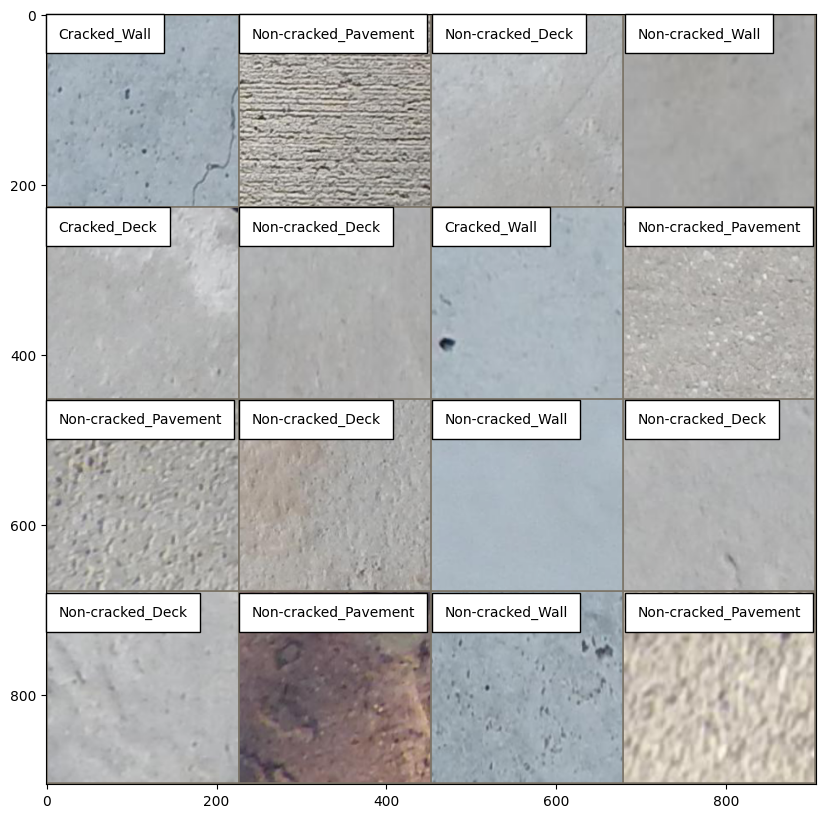

In [6]:
#Muestra de un batch de entrenamiento
def imshow(inp, classes):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  i = 0
  j = 0
  for x in classes:
      plt.text(i+14, j+27, class_names[x], bbox={'facecolor': 'white', 'pad': 9})
      i = i + 227
      if(i >= 800):
          j = j+227
          i = 0

  plt.show()
  plt.pause(0.001)

inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs, nrow = 4)
plt.figure(figsize=[10, 10])
imshow(out, classes)

In [7]:
#Arquitectura del modelo
import torchvision.models as models
class Network(nn.Module):
  def __init__(self):
    super(Network,self).__init__()
    self.fc1 = nn.Linear(500,50)
    self.fc2 = nn.Linear(50,6)

  def forward(self,x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return F.log_softmax(x)

model = models.resnet34(pretrained =True)
num_ft = model.fc.in_features
model.fc = nn.Linear(num_ft,500)

model2 = Network()
network = nn.Sequential(model, model2)

optimizer = optim.SGD(network.parameters(), lr=learning_rate)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 263MB/s]


In [ ]:
network

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [8]:
train_losses = []
train_counter = []
test_losses = []

test_counter = [i*len(train_loader.dataset) for i in range(num_epocas+1)]

#Entrenamiento
def train(epoch):
  network.train() #Modelo que combina Resnet34 con las dos capas
  for batchId, (data, target) in enumerate(train_loader):
    #Realizar forward-backward pass
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()

    if batchId % step_log == 0: #Cada 1260 imágenes
      print('Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batchId*len(data), len(train_loader.dataset), 100.*batchId/len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append((batchId*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(network.state_dict(), 'model.pth')
      #torch.save(optimizer.state_dict(), 'optimizer.pth')

#Testeo
def test():
  network.eval() #Modo test
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%) \n'.format(test_loss, correct, len(test_loader.dataset), 100.*correct/len(test_loader.dataset)))

In [9]:
#Carga del modelo entrenado
PATH = 'saved_data/checkpoint.pt'
PATH2 = 'saved_data/optimizer.pth'
optimizer.load_state_dict(torch.load(PATH2))
network.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [ ]:
for epoch in range(1, num_epocas+1):
  train(epoch)
  test()

<ipython-input-45-bbb34242b559>:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train epoch: 1 [0/42069 (0%)]	Loss: 0.245258
Train epoch: 1 [640/42069 (2%)]	Loss: 0.387608
Train epoch: 1 [1280/42069 (3%)]	Loss: 0.512013
Train epoch: 1 [1920/42069 (5%)]	Loss: 0.335699
Train epoch: 1 [2560/42069 (6%)]	Loss: 0.768995
Train epoch: 1 [3200/42069 (8%)]	Loss: 0.269330
Train epoch: 1 [3840/42069 (9%)]	Loss: 0.285801
Train epoch: 1 [4480/42069 (11%)]	Loss: 0.382922
Train epoch: 1 [5120/42069 (12%)]	Loss: 0.482173
Train epoch: 1 [5760/42069 (14%)]	Loss: 0.540051
Train epoch: 1 [6400/42069 (15%)]	Loss: 0.255815
Train epoch: 1 [7040/42069 (17%)]	Loss: 0.772822
Train epoch: 1 [7680/42069 (18%)]	Loss: 1.002262
Train epoch: 1 [8320/42069 (20%)]	Loss: 0.114368
Train epoch: 1 [8960/42069 (21%)]	Loss: 0.356400
Train epoch: 1 [9600/42069 (23%)]	Loss: 0.241500
Train epoch: 1 [10240/42069 (24%)]	Loss: 0.666439
Train epoch: 1 [10880/42069 (26%)]	Loss: 0.538528
Train epoch: 1 [11520/42069 (27%)]	Loss: 0.543427
Train epoch: 1 [12160/42069 (29%)]	Loss: 0.560841
Train epoch: 1 [12800/42069

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. Loss: 0.3657, Accuracy: 12298/14023 (88%) 



In [ ]:
#Se guarda el modelo
PATH = 'saved_data/checkpoint.pt'
PATH2 = 'saved_data/optimizer.pth'
torch.save(network.state_dict(), PATH)
torch.save(optimizer.state_dict(), PATH2)

In [ ]:
test()

<ipython-input-7-a843fca09d20>:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


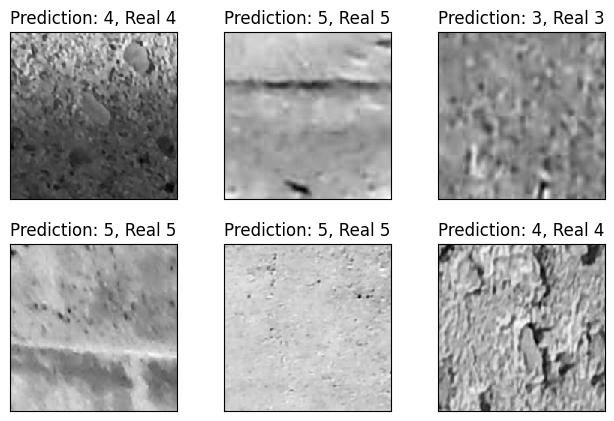

In [10]:
#Testeo de la red
import random

a = random.randint(0, 57)
examples = enumerate(test_loader)

batchId, (exampleData, exampleTarget) = next(examples)
with torch.no_grad():
  output = network(exampleData)

fig = plt.figure()
for i in range(a, a+6):
  plt.subplot(2,3,(i-a+1))
  plt.tight_layout()
  plt.imshow(exampleData[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}, Real {}".format(
    output.data.max(1, keepdim=True)[1][i].item(),exampleTarget[i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()
#Prediction: 0 -> Cracked_Deck
#Prediction: 1 -> Cracked_Pavement
#Prediction: 2 -> Cracked_Wall
#Prediction: 3 -> Non-cracked_Deck
#Prediction: 4 -> Non-cracked_Pavement
#Prediction: 5 -> Non-cracked_Wall